# Preliminaries

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

In [2]:
THIS = 'dissipation-theory--Study-50--'
figs = {}
obj = {}
df = {}

In [3]:
from dissipationtheory.constants import ureg, epsilon0, qe
from dissipationtheory.dissipation8a import CantileverModel, SampleModel1, SampleModel2
from dissipationtheory.dissipation8b import CantileverModelJit, SampleModel1Jit, SampleModel2Jit
from dissipationtheory.dissipation8b import integrand1jit, integrand2jit
from dissipationtheory.dissipation8c import twodimCobject

In [42]:
import cProfile

# Frequency shift data

Analyze data recorded by Virginia McGhee over gold on 08/11/2023.  This data was previously analyzed in Study 37.  The measured cantilever frequency was $62 \: \mathrm{kHz}$ and the manufacturer-specified spring constant was $2.8 \: \mathrm{N}/\mathrm{m}$.

In [4]:
filename = '20230811-ringdown-Gold_data_summary.csv'

cols_list = \
['Distance from Surface [nm]', 
 'Curvature [Hz/V^2]',
 'Curvature std [Hz/V^2]']

data = pd.read_csv(filename, usecols=cols_list)

In [5]:
rename_dict = \
    {'Distance from Surface [nm]': 'h [nm]',
     'Curvature [Hz/V^2]': 'f2 [Hz/V^2]',
     'Curvature std [Hz/V^2]': 'stdev f2 [Hz/V^2]'}

data.rename(columns=rename_dict, inplace=True)

In [6]:
def plotdata(data):
    
    fig = plt.figure(figsize=(3.50, 3.00))
    
    plt.errorbar(
        data['h [nm]'], 
        data['f2 [Hz/V^2]'],
        yerr=data['stdev f2 [Hz/V^2]'],
        fmt='.')

    plt.xlabel('tip-sample separation $h$ [nm]')
    plt.ylabel('$f_2$ [Hz/V$^2$]' )
    plt.xscale('log')
    plt.yscale('log')
    
    plt.tight_layout()

    return fig

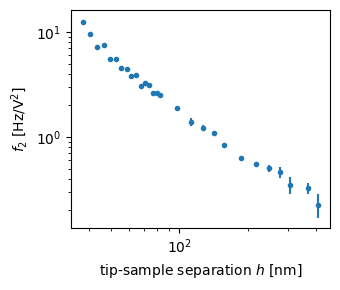

In [7]:
figs['01'] = plotdata(data)

What range of heights was measured?

In [18]:
print((np.min(data['h [nm]']), 
       np.max(data['h [nm]'])))

(37.5, 409.5)


# Sphere over metal

Assume a $R = 55 \: \mathrm{nm}$ tip, chosen by (not exhaustive) trial-and-error to roughly match the measured frequency shift at the point of closest approach.

In [284]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(62, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(55, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(1000, 'nm'), 
    d = ureg.Quantity(38, 'nm') # this parameter is ignored
)

sample1_metal = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(1e-6, 'nm'),  # not zero
    epsilon_s = ureg.Quantity(complex(1, 0), ''),
    sigma = ureg.Quantity(1e9, 'S/m'),
    rho = ureg.Quantity(1e26, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(50, 'nm')
)

sample1_jit_metal = SampleModel1Jit(**sample1_metal.args())

In [285]:
h_array = ureg.Quantity(data['h [nm]'].values, 'nm')

In [286]:
print("[{:d}]".format(len(h_array)), end=' ')
for index, h_ in enumerate(h_array): 

    obj['A'] = twodimCobject(sample1_jit_metal, integrand1jit)
    
    params = {'h': h_,
              'N': 15, # image charges
              'M': 30} # test points
    
    obj['A'].addsphere(**params)
    obj['A'].properties()

    results = {}
    results['h [nm]'] = obj['A'].info['h [nm]']
    results['calc f2 [Hz/V^2]'] = np.abs(obj['A'].results['Delta f [Hz]']/obj['A'].sample.cantilever.V_ts)
    
    if (index == 0):
        df['A'] = pd.DataFrame.from_dict([results])
    else:
        dfplus = pd.DataFrame.from_dict([results])
        df['A'] = pd.concat([df['A'], dfplus], ignore_index=True)   
    
    print(index,end=' ')

[28] 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 

**This computation is painfully slow!**

In [287]:
df['A']['f2 [Hz/V^2]'] = data['f2 [Hz/V^2]']
df['A']

,h [nm],calc f2 [Hz/V^2],f2 [Hz/V^2]
0,37.5,9.518633,12.548678
1,40.5,8.014522,9.644799
2,43.5,6.823989,7.194810
3,46.5,5.867057,7.497982
4,49.5,5.087530,5.519482
5,52.5,4.445009,5.582289
6,55.5,3.909872,4.565261
7,58.5,3.460014,4.433819
8,61.5,3.078679,3.801423
9,64.5,2.752987,3.871571


In [288]:
def compare(df):

    with plt.style.context('seaborn-v0_8'):
        
        fig, ax = plt.subplots(figsize=(3.5, 3.0))
        plt.loglog(df['h [nm]'], df['f2 [Hz/V^2]'], 'o', label='measured')
        plt.loglog(df['h [nm]'], df['calc f2 [Hz/V^2]'], '-', label='calculated')
        plt.xlabel('tip-sample separation $h$ [nm]')
        plt.ylabel('$f_2$ [Hz/V$^2$]')
        plt.legend(frameon=True, facecolor='w', fontsize=9)
        plt.tight_layout()
        
        return fig


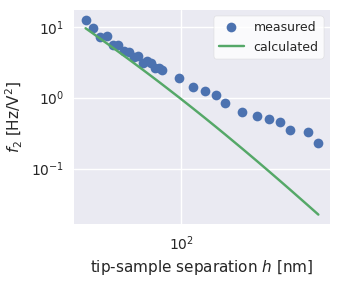

In [289]:
figs['01'] = compare(df['A'])

Modeling the tip as a sphere, Loring's equations predict the frequency shift correctly at small $h$ with a reasonable radius and essentially no other free parameters.  The frequency shift is underestimated at large $h$.

# Sphere plus cone over metal

Take the cone length to be $L = 2 \mu\mathrm{m}$ (chosen for convenience, speed).  Take $R = 41 \: \mathrm{nm}$ and $\theta = 19 \: \mathrm{degree}$, best-fit values obtained in Study 37.

In [290]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(62, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(41, 'nm'),
    angle = ureg.Quantity(19, 'degree'),
    L = ureg.Quantity(2000, 'nm'), 
    d = ureg.Quantity(38, 'nm') # this parameter is ignored
)

sample1_metal = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(1e-6, 'nm'),  # not zero
    epsilon_s = ureg.Quantity(complex(1, 0), ''),
    sigma = ureg.Quantity(1e9, 'S/m'),
    rho = ureg.Quantity(1e26, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(50, 'nm')
)

sample1_jit_metal = SampleModel1Jit(**sample1_metal.args())

In [291]:
print("[{:d}]".format(len(h_array)), end=' ')
for index, h_ in enumerate(h_array): 

    obj['B'] = twodimCobject(sample1_jit_metal, integrand1jit)
    
    params = {'h': h_}
    
    obj['B'].addtip(**params)
    obj['B'].properties()

    results = {}
    results['h [nm]'] = obj['B'].info['h [nm]']
    results['calc f2 [Hz/V^2]'] = np.abs(obj['B'].results['Delta f [Hz]']/obj['B'].sample.cantilever.V_ts)
    
    if (index == 0):
        df['B'] = pd.DataFrame.from_dict([results])
    else:
        dfplus = pd.DataFrame.from_dict([results])
        df['B'] = pd.concat([df['B'], dfplus], ignore_index=True)   
    
    print(index, end=' ')

[28] 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 

**This computation is painfully slow!!**

In [292]:
df['B']['f2 [Hz/V^2]'] = data['f2 [Hz/V^2]']
df['B']

,h [nm],calc f2 [Hz/V^2],f2 [Hz/V^2]
0,37.5,9.093227,12.548678
1,40.5,7.890723,9.644799
2,43.5,6.938258,7.194810
3,46.5,6.151121,7.497982
4,49.5,5.499873,5.519482
5,52.5,4.954322,5.582289
6,55.5,4.492252,4.565261
7,58.5,4.109797,4.433819
8,61.5,3.769030,3.801423
9,64.5,3.472657,3.871571


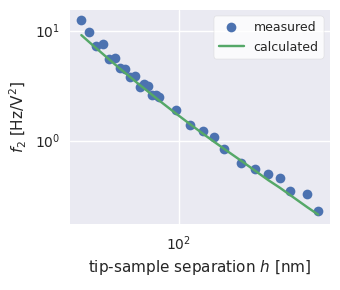

In [293]:
figs['02'] = compare(df['B'])

Modeling the tip as a sphere-plus-cone, Loring's equations now predict the frequency shift correctly at nearly all $h$, again using a reasonable radius, cone length, and cone angle and essentially no other free parameters.  The agreement at small $h$ could probably be improved by tweaking the tip radius, but the code runs painfully slowly and so I will skip this optimization for now.

# Run-time profiling and optimization

* "How To Profile Python Code" ([link](https://codesolid.com/how-do-i-profile-python-code/))
* "How not to be slow using Python: Functions" ([link](https://pawroman.dev/how-not-to-be-slow-using-python-functions/))
* "Scipy at lightspeed ⚡ Part 2" ([link](https://dev.to/zenulabidin/scipy-at-lightspeed-part-2-22i0)]

A representative sphere calculation.

In [65]:
%%time
obj['test A'] = twodimCobject(sample1_jit_metal, integrand1jit)

params = {'h': ureg.Quantity(15.0, 'nm'),
          'N': 15, # image charges
          'M': 30} # test points

obj['test A'].addsphere(**params)
obj['test A'].properties()

CPU times: user 3.42 s, sys: 55.7 ms, total: 3.48 s
Wall time: 3.77 s


The `.addsphere` function only takes 3 ms.

In [278]:
cProfile.run("obj['test A'].addsphere(**params)",sort='cumulative')

         1093 function calls (1091 primitive calls) in 0.016 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.016    0.016 {built-in method builtins.exec}
        1    0.000    0.000    0.016    0.016 <string>:1(<module>)
        1    0.005    0.005    0.015    0.015 dissipation8c.py:26(addsphere)
        2    0.000    0.000    0.005    0.002 quantity.py:516(to)
        3    0.000    0.000    0.004    0.001 registry.py:59(parse_units_as_container)
        3    0.000    0.000    0.004    0.001 registry.py:1214(parse_units_as_container)
        3    0.001    0.000    0.004    0.001 registry.py:1228(_parse_units_as_container)
        6    0.000    0.000    0.004    0.001 util.py:1031(to_units_container)
        3    0.000    0.000    0.004    0.001 quantity.py:188(__new__)
        7    0.002    0.000    0.003    0.000 util.py:965(__new__)
        2    0.000    0.000    0.002    0.001 registry.

The function `.solve` is very slow, 4.3 seconds for a $15 \times 30 = 450$ element array.  Of that, 3.26 seconds is spent in `_Ksample` and 1.38 seconds is spent in `quad`. 

In [68]:
cProfile.run("obj['test A'].solve(0.)",sort='cumulative')

         2376343 function calls (2365543 primitive calls) in 4.271 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    4.278    4.278 {built-in method builtins.exec}
        1    0.000    0.000    4.278    4.278 <string>:1(<module>)
        1    0.000    0.000    4.278    4.278 dissipation8c.py:234(solve)
     1350    0.073    0.000    3.262    0.002 dissipation8c.py:205(_Ksample)
     2700    0.044    0.000    2.378    0.001 dissipation8b.py:321(K_jit)
    25200    0.204    0.000    1.377    0.000 quantity.py:188(__new__)
     2700    0.013    0.000    1.373    0.001 _quadpack_py.py:23(quad)
     2700    0.006    0.000    1.356    0.001 _quadpack_py.py:557(_quad)
     2700    1.065    0.000    1.350    0.000 {built-in method scipy.integrate._quadpack._qagie}
    15750    0.047    0.000    1.330    0.000 quantity.py:93(wrapped)
        1    0.000    0.000    1.205    1.205 dissipation8c.py:268(<

In [69]:
cProfile.run("obj['test A'].properties()",sort='cumulative')

         4802041 function calls (4780405 primitive calls) in 8.371 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    8.386    8.386 {built-in method builtins.exec}
        1    0.000    0.000    8.385    8.385 <string>:1(<module>)
        1    0.000    0.000    8.385    8.385 dissipation8c.py:280(properties)
        2    0.001    0.000    8.361    4.181 dissipation8c.py:234(solve)
     2700    0.134    0.000    7.167    0.003 dissipation8c.py:205(_Ksample)
     5400    0.089    0.000    5.350    0.001 dissipation8b.py:321(K_jit)
     5400    0.024    0.000    3.174    0.001 _quadpack_py.py:23(quad)
     5400    0.013    0.000    3.141    0.001 _quadpack_py.py:557(_quad)
     5400    2.568    0.000    3.129    0.001 {built-in method scipy.integrate._quadpack._qagie}
        2    0.000    0.000    3.031    1.516 dissipation8c.py:268(<listcomp>)
    31539    0.089    0.000    2.619    0.000 quant

How many total points?

In [49]:
obj['test'].info['N'] * obj['test'].info['M']

450

Why so many function calls?  It is because I build arrays many times over (the Coulomb part; the K real part and K imaginary part, times three).  I should be calling `_Ksample` (returning a complex number) 450 x 3 = 1350 times.  This is exactly what I see; the function `solve` calling `_Ksample` 1350 times.

The core function we are calling over and over is `integrand1jit`.  How long does a single function call take?

In [173]:
integrand1jit(0.11, 0, sample1_jit_metal, 1e5, obj['test'].rj[4] * 1e-9,  obj['test'].rk[5] * 1e-9, False)

0.8690437772759312

In [174]:
%%timeit
integrand1jit(0.11, 0, sample1_jit_metal, 1e5, obj['test'].rj[4] * 1e-9,  obj['test'].rk[5] * 1e-9, False)

9.19 μs ± 2.67 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The main function that calls `integrand1jit` is `K_jit`, which is actually not a compiled function as the name implies.  The function `K_jit` integrates the function `integrand1jit` from $0$ to $\infty$.  Let's see how many function calls 
that takes on average.


In [105]:
from dissipationtheory.dissipation8b import K_jit
from scipy import integrate

Pick some values that return a non-trivial answer.

In [154]:
K_jit(integrand1jit, 0, sample1_jit_metal, 0., obj['test'].rj[4] * 1e-9,  obj['test'].rk[5] * 1e-9, False)

<Quantity(14589288.888617216, '1 / meter')>

In [139]:
%%timeit
K_jit(integrand1jit, 0, sample1_jit_metal, 0., obj['test'].rj[4] * 1e-9,  obj['test'].rk[5] * 1e-9, False)

427 μs ± 51.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


The integration takes, on average, about 72 function calls.  We'll see below that `scipy.integrate.quad` returns an estimated error of about $1$ part on $10^{10}$.  That is a remarkably good error considering how few function calls are made to `integrand1jit`.  I don't know how good the error estimate *actually* is.  I do know that our capacitance calculations appear to be good to at least a few parts in $10^{6}$. 

Write a version of the `K_jit` function without units handling, that just returns the real part of the integrand (removing an if-then loop).

In [131]:
def K_jit_real_new(integrand, power, sample, omega, location1, location2):
    """Compute the integral :math:`K`.  The answer is returned without units. """

    return integrate.quad(integrand, 0., np.inf, args=(power, sample, omega, location1, location2, False))

Make sure we have picked values that return a non-trivial answer.

In [132]:
K_jit_real_new(integrand1jit, 0, sample1_jit_metal, 0., obj['test'].rj[4] * 1e-9,  obj['test'].rk[5] * 1e-9)

(0.7294644444308608, 8.076597024893128e-11)

Note how small the error is!

In [140]:
%%timeit
K_jit_real_new(integrand1jit, 0, sample1_jit_metal, 0., obj['test'].rj[4] * 1e-9,  obj['test'].rk[5] * 1e-9)

291 μs ± 38.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Ok, a slight speedup (maybe 25%) was obtained by stripping out the units handling and the if-then loop.

Play with the `integrate.quad` function call to see if we can speed it up a little bit.  Turn down the relative tolerance to only `1e-3` (about our noise level).

In [165]:
integrate.quad(integrand1jit, 0., np.inf, epsrel=1e-03,
    args=(0, sample1_jit_metal, 0., obj['test'].rj[4] * 1e-9,  obj['test'].rk[5] * 1e-9, False))

(0.7294644469834035, 0.00020766808959750242)

In [166]:
%%timeit
integrate.quad(integrand1jit, 0., np.inf, epsrel=1e-03,
    args=(0, sample1_jit_metal, 0., obj['test'].rj[4] * 1e-9,  obj['test'].rk[5] * 1e-9, False))

149 μs ± 11.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


This gets you only a factor of 2 speedup!

Now time how I do the looping to set up the matrix.  The code below isn't exactlyl what I do, but it's similar.

In [198]:
%%timeit
np.array([[
    (obj['test'].zr * K_jit(integrand1jit, 0, sample1_jit_metal, 0., rj * 1e-9,  rk * 1e-9, False)).to('').magnitude
    for rj in obj['test'].rj] for rk in obj['test'].rk])

216 ms ± 30.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


What do I expect?  I would expect 0.4 ms/pt x 450 pts = 180 ms, which is approximately what I see.  I conclude that there does not seem to be a lot of functional overhead when looping using a list comprehension.

Now make a stripped-down function ...

In [199]:
def K_jit_real_new(integrand, power, sample, omega, location1, location2):
    """Compute the integral :math:`K`.  The answer is returned without units. """

    return integrate.quad(integrand, 0., np.inf, args=(power, sample, omega, location1, location2, False))[0]

... and loop it ...

In [200]:
%%timeit
np.array([[
    K_jit_real_new(integrand1jit, 0, sample1_jit_metal, 0., rj * 1e-9,  rk * 1e-9)
    for rj in obj['test'].rj] for rk in obj['test'].rk])

142 ms ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


OK, somewhat faster, by a factor of maybe 1.5.

# Next steps

- Plot the evaluation time versus the number of image-charge points (it should grow quadratically)
- Determine the shortest length of cone needed for 1%-level convergence (minmize the total number of image-charge points)
- Modify the `.addsphere` function to optionally use half as many voltage-test points, varying the angle over $\pi$ instead of $2 \pi$ (a free factor of 4 speedup)
- Write a function to rapidly compute the response function of a metal (for fast data fitting to obtain tip radius, cone angle)
- Compare the evaluation of `K_jit` with `integrand1jit` and `integrand2jit` (expect the second one to be faster)
- Make a Type III sample, a semi-infinite semiconductor, and an associated integrand `integrand3jit` (should evaluate even faster, for first-pass data analysis)
- Implement vector integration (Google "python integrating a vector function", see the code beloe; integrate K0, K1, K2 all at once; a possible 6-fold speedup)
- Remove units and if-then statements from functions (tedious; this may also speed things up)
- Look into pre-computing constants in the integrands (a painful recoding would be required; this may speed things up)


If the sample is thick enough, we can model it as a Type III sample which could speed up computations considerably.

# Explore vector integration

We can't integrate a complex-values function, but we can integrate a vector function.

In [252]:
def func(x):
    return np.array([np.cos(2 * np.pi * x), np.sin(2 * np.pi * x)])

In [253]:
func(0.125)

array([0.70710678, 0.70710678])

In [254]:
integrate.quad_vec(func, 0., 0.25)

(array([0.15915494, 0.15915494]), 7.908415680563028e-15)

We can collapse the vector result into a single complex number by taking the dot product with the vector $(1,i)$

In [255]:
integrate.quad_vec(func, 0., 0.25)[0] @ np.array([complex(1,0), complex(0,1)])

(0.15915494309189532+0.15915494309189532j)

I think I can use this trick to integrate $K_0$, $K_1$, $K_2$ all a once.  Why do I expect this to be faster?  Each integrand differs by only a factor of $y^{\ell}$ or $\text{Re}(r_p(y,\omega))$ versus $\text{Im}(r_p(y,\omega))$.  Computing $r_p(y,\omega)$ is the computationally expensive part, and we just need to do that once per six computations.

Let's explore a little more how this might work.

In [259]:
def func(x):
    return np.array([np.cos(2 * np.pi * x), 
                     np.sin(2 * np.pi * x),
                     np.exp(-x) * np.cos(2 * np.pi * x), 
                     np.exp(-x) * np.sin(2 * np.pi * x),
                     np.exp(-2 * x) * np.cos(2 * np.pi * x), 
                     np.exp(-2 * x) * np.sin(2 * np.pi * x)])

In [260]:
integrate.quad_vec(func, 0., 0.25)[0]

array([0.15915494, 0.15915494, 0.14559239, 0.13598319, 0.13365124,
       0.11661243])

How to reduce this result to three complex numbers?

Here is one way:

In [265]:
integrate.quad_vec(func, 0., 0.25)[0] @ np.array([[complex(1,0), complex(0,1), 0, 0, 0, 0],
                                                  [0, 0, complex(1,0), complex(0,1), 0, 0],
                                                  [0, 0, 0, 0, complex(1,0), complex(0,1)]]).T

array([0.15915494+0.15915494j, 0.14559239+0.13598319j,
       0.13365124+0.11661243j])

Here is another way:

In [272]:
ans = integrate.quad_vec(func, 0., 0.25)[0] @ np.array([[complex(1,0), 0, 0],
                                                       [complex(0,1), 0, 0],
                                                       [0, complex(1,0), 0],
                                                       [0, complex(0,1), 0],
                                                       [0, 0, complex(1,0)],
                                                       [0, 0, complex(0,1)]])

In [273]:
K0, K1, K2 = ans

In [274]:
K0

(0.15915494309189532+0.15915494309189532j)

In [275]:
K1

(0.14559239185228917+0.13598319425203134j)

In [276]:
K2

(0.1336512423781951+0.11661243134216984j)

::: {.content-hidden when-format="html"}

# Save the figures

In [294]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-50.ipynb && open dissipation-theory--Study-50.html
    
:::